<a href="https://colab.research.google.com/github/ngcheeyuan/Learner-s-Repo-for-Tensorflow/blob/main/08_nlp_with_tensorflow_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2022-01-15 02:20:45--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-01-15 02:20:45 (90.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
from helper_functions import unzip_data , create_tensorboard_callback, plot_loss_curves , compare_historys

In [6]:
## Get a text dataset - disaster / not disaster
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
unzip_data('nlp_getting_started.zip')

--2022-01-15 02:23:16--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.128, 142.250.141.128, 2607:f8b0:4023:c03::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.04s   

2022-01-15 02:23:16 (16.5 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [7]:
import pandas as pd

In [11]:
df_train = pd.read_csv('train.csv')

In [12]:
df_test = pd.read_csv('test.csv')

In [15]:
df_test.head(5) # no labels in test data

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [17]:
df_train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [33]:
X_train

5740    VIDEO: 'We're picking up bodies from water': R...
1508    The best part of old baseball managers wearing...
6549    The 'twins' survived their first day of high s...
972     Louis Vuitton Monogram Sophie Limited Edition ...
5562    Landslide in Italian Alps kills three: ROME (R...
                              ...                        
4836    @yelllowheather controlled murder is fine. mas...
2379    Will @FoxNews continue to derail the Iran Nucl...
5652    UD: Rescue (Structural Collapse) - Scott Road ...
6103    that horrible sinking feeling when youÛªve be...
759     Rick and Morty - They Blew Up : http://t.co/UQ...
Name: text, Length: 5709, dtype: object

In [19]:
X = df_train['text']
y = df_train['target']

In [20]:
from sklearn.model_selection import train_test_split

In [31]:
X_train , X_val , y_train, y_val = train_test_split(X,y,test_size = 0.25, stratify = y)

In [32]:
y_train.mean(),y_val.mean() , len(X_train), len(y_val)

(0.4296724470134875, 0.42962184873949577, 5709, 1904)

In [41]:
df = pd.concat([X_train,y_train] , axis = 1)

In [54]:
#Let's visualise some random training examples

import random
random_index = random.randint(0,len(X_train)-5)

for row in df[random_index:random_index+5].itertuples():
 _,text,target = row
 print(f'target : {target}', 'real_disaster\n' if target >0 else 'not_disaster\n' , f'text : {text}\n')
 print('------\n')

target : 0 not_disaster
 text : @Morning_Joe @Reince @PressSec Joe ur so smart u should run 4 president Ur perfect !The American people love assholes u'd win by a landslide

------

target : 1 real_disaster
 text : Some people are really natural disaster too

------

target : 1 real_disaster
 text : Drones Under Fire: Officials Offer $75000 Reward Leading To Pilots Who Flew Over Wildfire http://t.co/d2vEppeh8S #photography #arts

------

target : 1 real_disaster
 text : Reid Lake fire prompts campground evacuation order http://t.co/jBODKM6rBU

------

target : 1 real_disaster
 text : Cross-border terrorism: Pakistan caught red-handed again http://t.co/uDj50J3MV4

------



## tokenization & embedding

* tokenization - straight character/word/subword to number

* embedding - every word becomes a vector - richer representation between tokens -Word2Vec , GloVe

In [72]:
## tokenization
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

In [77]:
text_vec = TextVectorization(max_tokens= 5000,
                             standardize = 'lower_and_strip_punctuation',
                             split = 'whitespace',
                             ngrams = None,
                             output_mode = 'int',
                             output_sequence_length = None, #pad text to have the same length as the longest text,
                             pad_to_max_tokens = True)

In [83]:
#Average number of tokens in the training tweets
round(sum([len(i.split()) for i in X_train])/len(X_train))

15

In [85]:
#setup text vectorization variables

max_vocab_length = 10000 # max num of words to have in our vocab
max_length = 15 # max length of our sequence

text_vectorizer = TextVectorization(max_tokens = max_vocab_length,
                                    output_sequence_length = max_length)

In [86]:
#Fit the text vectorizer to the training text
text_vectorizer.adapt(X_train)

In [90]:
#create a sample sentence and tokenize it

sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[259,   3, 192,   4,  13, 757,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [93]:
#choose a random sentence from the training dataset and tokenize it

random_sentence = random.choice(X_train)
print(f'original text:\n {random_sentence} \
        \n\nVectorized version:')
text_vectorizer([random_sentence])

original text:
 OSP concerned about mounting fatalities http://t.co/YmP0gInwza http://t.co/FYIOQvIOif         

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[8981, 1881,   52, 9477,  285,    1,    1,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [95]:
# get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]

In [101]:
len(words_in_vocab),top_5_words , bottom_5_words

(10000,
 ['', '[UNK]', 'the', 'a', 'in'],
 ['losangeles', 'lorry', 'loretta', 'lore', 'lopezandthelion'])

### Create an embedding layer 
reference : https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

The parameters we care most about for our embedding layer:
* input_dims = the size of our vocabulary
* output_dims = the size of the output embedding vector, a value of 100 would mean each token gets represented by a vector 100 long
* input_lnegth = length of the sequence being passed to the embedding layer 

In [103]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim = max_vocab_length,
                             output_dim = 128,
                             input_length = max_length)
embedding

In [110]:
random_sentence = random.choice(X_train)
print(f'original sentence: {random_sentence}')
print('embedded sentence: \n')
sampled_embed = embedding(text_vectorizer([random_sentence]))
sampled_embed

original sentence: Downtown Emergency Service Center is hiring! #Chemical #Dependency Counselor or Intern in #Seattle apply now! #jobs http://t.co/SKQPWSNOin
embedded sentence: 



<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.04944539,  0.04037405, -0.04081986, ...,  0.00388252,
         -0.01702844,  0.02214609],
        [-0.01620657,  0.04914521, -0.04942518, ..., -0.00988957,
         -0.03543322,  0.01118841],
        [ 0.00768814,  0.02774942, -0.0049371 , ...,  0.04154738,
         -0.00191029, -0.03607891],
        ...,
        [ 0.04287002, -0.01480588, -0.03319335, ...,  0.01150355,
         -0.04213332, -0.0372829 ],
        [-0.01833663,  0.00146604,  0.02814621, ..., -0.0164618 ,
         -0.00345272, -0.01905504],
        [ 0.04219855, -0.00685462, -0.00658493, ..., -0.0284266 ,
         -0.00797322, -0.00803772]]], dtype=float32)>

In [115]:
sampled_embed[0][0],sampled_embed[0][0].shape, random_sentence, text_vectorizer([random_sentence])

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.04944539,  0.04037405, -0.04081986, -0.02289185,  0.01092731,
        -0.02358   , -0.01146393, -0.0350467 , -0.01117951,  0.03443919,
         0.04162939, -0.01438476,  0.02754383, -0.02871627,  0.04556448,
        -0.04880804,  0.01672919,  0.00195135, -0.03829076, -0.02524284,
        -0.04601251, -0.03189303,  0.02761498, -0.00169505,  0.0483521 ,
        -0.00157613, -0.04796144, -0.01537554,  0.04069507, -0.04892487,
         0.04520634, -0.01125417,  0.00832789, -0.03282966, -0.03243369,
        -0.04193339, -0.02511194,  0.01885872, -0.03237641, -0.00479548,
        -0.02375308,  0.03799135,  0.03571931, -0.01210807,  0.0190069 ,
         0.04948295, -0.01094959,  0.01033096, -0.00967931, -0.01963001,
         0.04906949, -0.04457519, -0.04888879, -0.00516742,  0.01409291,
         0.04619911,  0.01247301,  0.03141513, -0.03049445, -0.0053605 ,
         0.00405968, -0.03420593,  0.03578899,  0.01086663,  0.01940061,
  

# Modelling a text dataset
* 0 - baseline - Naive Bayes with TF-ID encoder
* 1 - feed-forwad neural network
* 2 - LSTM (RNN)
* 3 - GRU (RNN)
* 4 - Bidirectional-LSTM(RNN)
* 5 - 1D CNN
* 6 - Tensorhub Pretrained Feature Extractor (Transfer learning)
* 7 - Tensorhub Pretrained Feature Extract (10% of data)

### Moel 0 : getting a baseline

In [118]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [121]:
model_0 = Pipeline([('tfidf',TfidfVectorizer()),
                     ('clf',MultinomialNB())])

In [122]:
model_0.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [123]:
from sklearn.metrics import accuracy_score

In [127]:
baseline_score_train = model_0.score(X_train,y_train)
baseline_score_val = model_0.score(X_val,y_val)
baseline_score_train,baseline_score_val

(0.8887721142056402, 0.7993697478991597)

In [128]:
from sklearn.metrics import accuracy_score, f1_score , precision_score, recall_score
from sklearn.metrics import classification_report

In [181]:
def evaluation_metrics(y_preds_train,
                       y_preds_val,
                       y_train,
                       y_val):
  
  '''
  Calculates model accuracy, precision, recall, f1 score of a binary classification model
  '''


 # can use precision_recall_fscore_support 

  return {'accuracy_train':accuracy_score(y_train,y_preds_train),
          'accuracy_val':accuracy_score(y_val,y_preds_val),
          'precision_train':precision_score(y_train,y_preds_train),
          'precision_val':precision_score(y_val,y_preds_val),
          'recall_train':recall_score(y_train,y_preds_train),
          'recall_val':recall_score(y_val,y_preds_val),
          'f1_train':f1_score(y_train,y_preds_train,),
          'f1_val':f1_score(y_val,y_preds_val)}

In [182]:
y_pred_train = model_0.predict(X_train)
y_pred_val = model_0.predict(X_val)
baseline_results = evaluation_metrics(y_pred_train,y_pred_val,y_train,y_val)
baseline_results

{'accuracy_train': 0.8887721142056402,
 'accuracy_val': 0.7993697478991597,
 'f1_train': 0.8568207440811726,
 'f1_val': 0.7255747126436782,
 'precision_train': 0.958627648839556,
 'precision_val': 0.8797909407665505,
 'recall_train': 0.7745617611088463,
 'recall_val': 0.617359413202934}

### Model 1 : Feed-forward neural network (dense model)

In [148]:
# Create a tensorboard callback
from helper_functions import create_tensorboard_callback

#create a directory to save tensorboard logs
SAVE_DIR = 'model_logs'

In [159]:
#build model with functional API
from tensorflow.keras import layers
inputs = layers.Input(shape =(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x) # create an embedding of the numberized inputs
x = layers.GlobalAveragePooling1D()(x) #condense the feature vector for each token to one vector
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model_1 = tf.keras.Model(inputs,outputs,name = 'model_1_dense')

In [160]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_13 (Text  (None, 15)               0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [151]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_13 (Text  (None, 15)               0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 dense (Dense)               (None, 15, 1)             129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [152]:
#Compile model
model_1.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [154]:
model_1_history = model_1.fit(x=X_train,
                              y=y_train,
                              epochs = 5,
                              validation_data = (X_val,y_val),
                              callbacks = [create_tensorboard_callback(dir_name = SAVE_DIR,
                                                                       experiment_name = 'model_1_dense')])

Saving TensorBoard log files to: model_logs/model_1_dense/20220115-041305
Epoch 1/5
179/179 [==============================] - 3s 13ms/step - loss: 0.6546 - accuracy: 0.6338 - val_loss: 0.6273 - val_accuracy: 0.6587
Epoch 2/5
179/179 [==============================] - 2s 12ms/step - loss: 0.5993 - accuracy: 0.6925 - val_loss: 0.6200 - val_accuracy: 0.6594
Epoch 3/5
179/179 [==============================] - 2s 11ms/step - loss: 0.5745 - accuracy: 0.6936 - val_loss: 0.6240 - val_accuracy: 0.6592
Epoch 4/5
179/179 [==============================] - 2s 12ms/step - loss: 0.5628 - accuracy: 0.6945 - val_loss: 0.6314 - val_accuracy: 0.6582
Epoch 5/5
179/179 [==============================] - 2s 12ms/step - loss: 0.5573 - accuracy: 0.6944 - val_loss: 0.6345 - val_accuracy: 0.6586


In [156]:
model_1.evaluate(X_val,y_val)

60/60 [==============================] - 0s 2ms/step - loss: 0.6345 - accuracy: 0.6586


[0.6345201730728149, 0.6586484313011169]

In [157]:
model_1_pred_probs = model_1.predict(X_val)
model_1_pred_probs.shape

(1904, 15, 1)

In [158]:
model_1_pred_probs[0]

array([[0.1985704 ],
       [0.1126219 ],
       [0.38585526],
       [0.21389925],
       [0.38323477],
       [0.38323477],
       [0.38323477],
       [0.38323477],
       [0.38323477],
       [0.38323477],
       [0.38323477],
       [0.38323477],
       [0.38323477],
       [0.38323477],
       [0.38323477]], dtype=float32)

In [162]:
model_1.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

model_1_corrected_history = model_1.fit(x=X_train,
                                        y=y_train,
                                        epochs = 5,
                                        validation_data = (X_val,y_val),
                                        callbacks = [create_tensorboard_callback(dir_name = SAVE_DIR,
                                                                                experiment_name = 'model_1_dense_corrected')])

Saving TensorBoard log files to: model_logs/model_1_dense_corrected/20220115-041646
Epoch 1/5
179/179 [==============================] - 3s 13ms/step - loss: 0.5878 - accuracy: 0.7462 - val_loss: 0.5400 - val_accuracy: 0.7637
Epoch 2/5
179/179 [==============================] - 2s 12ms/step - loss: 0.4215 - accuracy: 0.8522 - val_loss: 0.4700 - val_accuracy: 0.7878
Epoch 3/5
179/179 [==============================] - 2s 12ms/step - loss: 0.3304 - accuracy: 0.8793 - val_loss: 0.4499 - val_accuracy: 0.8009
Epoch 4/5
179/179 [==============================] - 2s 12ms/step - loss: 0.2716 - accuracy: 0.9030 - val_loss: 0.4476 - val_accuracy: 0.8009
Epoch 5/5
179/179 [==============================] - 2s 12ms/step - loss: 0.2271 - accuracy: 0.9203 - val_loss: 0.4588 - val_accuracy: 0.7988


In [163]:
model_1.evaluate(X_val,y_val)

60/60 [==============================] - 0s 2ms/step - loss: 0.4588 - accuracy: 0.7988


[0.4587961435317993, 0.7988445162773132]

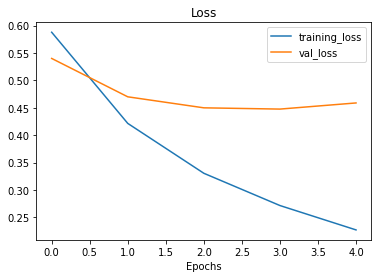

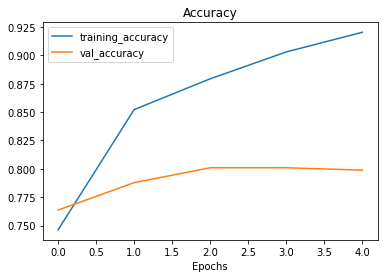

In [164]:
plot_loss_curves(model_1_corrected_history)

In [183]:
model_1_pred_probs_val = model_1.predict(X_val)
model_1_pred_probs_train = model_1.predict(X_train)

In [184]:
import numpy as np
model_1_preds_val = tf.cast(tf.squeeze(tf.round(model_1_pred_probs_val)), dtype = tf.int16)
model_1_preds_train = tf.cast(tf.squeeze(tf.round(model_1_pred_probs_train)), dtype = tf.int16)
model_1_preds_val,model_1_preds_train

(<tf.Tensor: shape=(1904,), dtype=int16, numpy=array([0, 1, 0, ..., 0, 0, 0], dtype=int16)>,
 <tf.Tensor: shape=(5709,), dtype=int16, numpy=array([1, 0, 0, ..., 1, 1, 0], dtype=int16)>)

In [191]:
model_1_results = evaluation_metrics(model_1_preds_train,
                                     model_1_preds_val,
                                     y_train,
                                     y_val)

In [192]:
model_1_results

{'accuracy_train': 0.9393939393939394,
 'accuracy_val': 0.7988445378151261,
 'f1_train': 0.9266327396098388,
 'f1_val': 0.7530625402965827,
 'precision_train': 0.9655324790101635,
 'precision_val': 0.7967257844474761,
 'recall_train': 0.8907460252751732,
 'recall_val': 0.7139364303178484}

In [193]:
baseline_results

{'accuracy_train': 0.8887721142056402,
 'accuracy_val': 0.7993697478991597,
 'f1_train': 0.8568207440811726,
 'f1_val': 0.7255747126436782,
 'precision_train': 0.958627648839556,
 'precision_val': 0.8797909407665505,
 'recall_train': 0.7745617611088463,
 'recall_val': 0.617359413202934}

In [194]:
np.array(list(model_1_results.values())) >np.array(list(baseline_results.values()))

array([ True, False,  True, False,  True,  True,  True,  True])